## Modeling *Ironsworn*’s core mechanic in [``dyce``](https://posita.github.io/dyce/)

Select ``Run All Cells`` from the ``Run`` menu above.

In [1]:
# Install additional requirements if necessary
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    try:
        import anydyce, tabulate
    except (ImportError, ModuleNotFoundError):
        requirements = ["anydyce~=0.1", "tabulate"]
        try:
            import piplite ; await piplite.install(requirements)
        except ImportError:
            import pip ; pip.main(["install"] + requirements)
    import anydyce, tabulate

In [2]:
from dyce import H
from enum import IntEnum, auto

class IronSoloResult(IntEnum):
    SPECTACULAR_FAILURE = -1
    FAILURE = auto()
    WEAK_SUCCESS = auto()
    STRONG_SUCCESS = auto()
    SPECTACULAR_SUCCESS = auto()

d6 = H(6)
d10 = H(10)

def iron_solo_dependent_term(action, first_challenge, second_challenge, mod=0):
    modded_action = action + mod
    beats_first = modded_action > first_challenge
    beats_second = modded_action > second_challenge
    doubles = first_challenge == second_challenge

    if beats_first and beats_second:
        return (
            IronSoloResult.SPECTACULAR_SUCCESS
            if doubles
            else IronSoloResult.STRONG_SUCCESS
        )
    elif beats_first or beats_second:
        return IronSoloResult.WEAK_SUCCESS
    else:
        return (
            IronSoloResult.SPECTACULAR_FAILURE
            if doubles
            else IronSoloResult.FAILURE
        )

,SPECTACULAR_FAILURE,FAILURE,WEAK_SUCCESS,STRONG_SUCCESS,SPECTACULAR_SUCCESS
Modifier,,,,,
0,7.50%,51.67%,31.67%,6.67%,2.50%
1,6.50%,38.67%,39.67%,11.67%,3.50%
2,5.50%,27.67%,43.67%,18.67%,4.50%
3,4.50%,18.67%,43.67%,27.67%,5.50%
4,3.50%,11.67%,39.67%,38.67%,6.50%


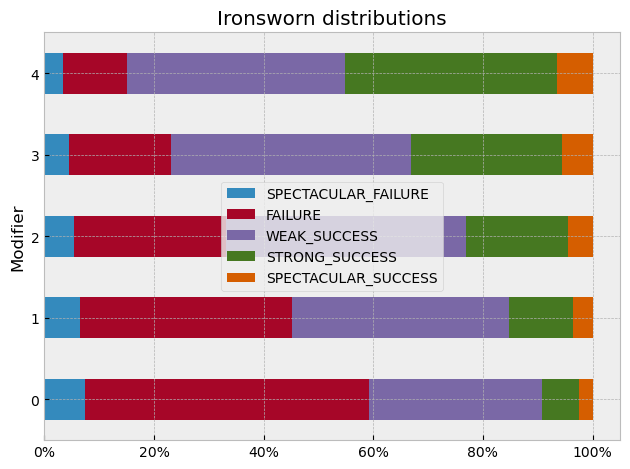

In [3]:
from functools import partial
from IPython.display import display
from pandas import DataFrame, concat
import jinja2  # to appease the JupyterLite loader
import matplotlib, pandas

mods = list(range(0, 5))
df = pandas.DataFrame(columns=IronSoloResult)
results_by_mod: dict[int, H] = {}

for mod in mods:
    res_for_mod = H.foreach(
        partial(iron_solo_dependent_term, mod=mod),
        action=d6,
        first_challenge=d10,
        second_challenge=d10,
    ).zero_fill(IronSoloResult)
    results_for_mod = dict(
        res_for_mod.distribution(rational_t=lambda n, d: n / d)
    )
    row = pandas.DataFrame(results_for_mod, columns=IronSoloResult, index=[mod])
    df = pandas.concat((df, row))
    results_by_mod[mod] = res_for_mod

df.index.name = "Modifier"
# DataFrames use enum's values for displaying column names, so we convert them to names
df = df.rename(columns={v: v.name for v in IronSoloResult})
display(df.style.format({v.name: "{:.2%}" for v in IronSoloResult}))

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.style.use("bmh")
ax = df.plot(kind="barh", stacked=True)
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
ax.legend()
ax.set_title("Ironsworn distributions")
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [4]:
from anydyce.viz import BreakoutType, jupyter_visualize

jupyter_visualize(
    [
        (f"Modifier: {mod:+}", results_by_mod[mod]) for mod in mods
    ],
    default_breakout_type=BreakoutType.BURST,
    default_main_plot_type="bar",
)